# Color manipulation of images

This is a starter notebook for manipulating images - specifically downsampling the color profile of an image.

First we will import our usual things and create a function that will help us change the # of colors in an image:

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

# we won't use these packages directly, but the function that picks colors will
import scipy
import scipy.misc
import scipy.cluster

# If you haven't yet, you may need to install scipy
#!conda install -c anaconda scipy


# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

Specify the directory path to your image:

In [23]:
path_to_image = '/Users/jillnaiman/Downloads/littleCorgiInHat.png'

Read in image:

In [24]:
im = Image.open(path_to_image)

Take a quick look:

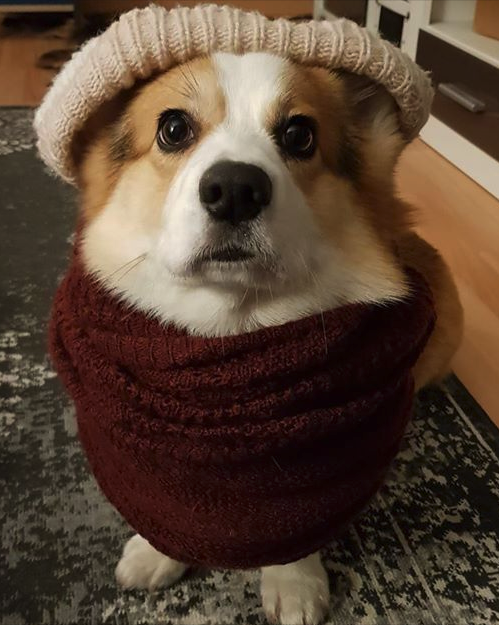

In [25]:
im

Convert to an 8-color image for easier handling:

In [26]:
new_im, new_rgbs = convert_image(im, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[116.97488804  90.13498093  63.21698457]
 [ 46.91049776  24.90636096  17.81771287]
 [153.20655    120.72443601  86.04480287]
 [ 86.79257259  69.40488851  50.36432727]
 [ 23.04248331   8.20002169   6.24064577]
 [211.9982032  197.75739229 175.93207297]
 [179.66287081 158.22114833 129.26220096]
 [ 63.58550613  46.56138544  33.38852765]]


Take a quick look:

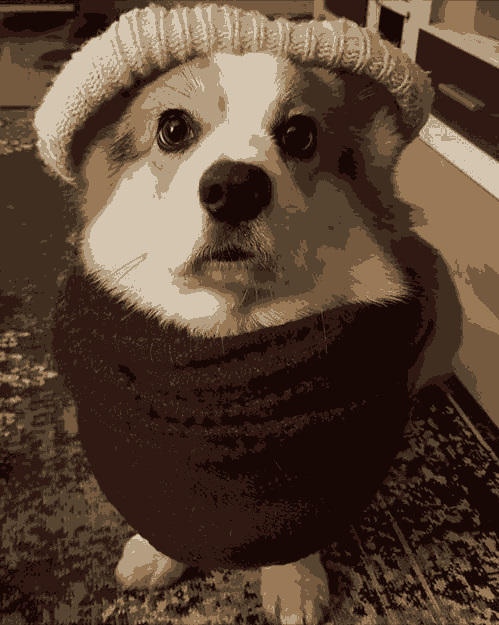

In [27]:
new_im

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [7]:
new_im_data = np.array(new_im)

In [8]:
np.unique(new_im_data.reshape(-1, new_im_data.shape[2]), axis=0)

array([[ 23,   8,   6],
       [ 47,  25,  18],
       [ 64,  47,  33],
       [ 87,  70,  50],
       [117,  90,  63],
       [153, 121,  86],
       [180, 158, 129],
       [212, 198, 176]], dtype=uint8)

Can also give your own set of color sequences instead as a list of RGB triplets:

In [28]:
new_im2, new_rgbs2 = convert_image_specific(im, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

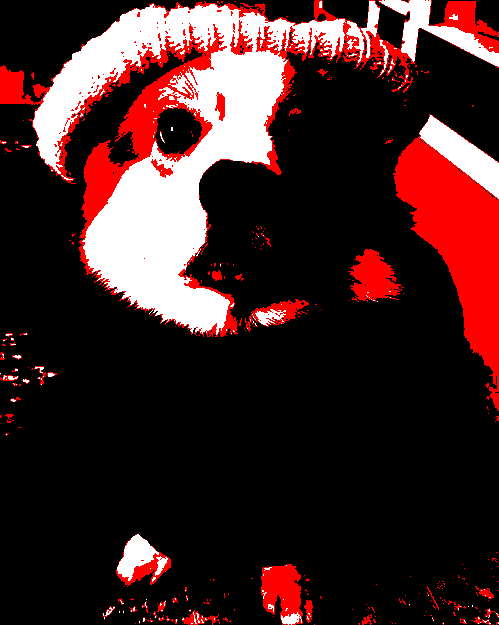

In [29]:
new_im2